# Setup

In [24]:
!pip install goodfire

In [25]:
from google.colab import userdata
import goodfire
import numpy as np
import matplotlib.pyplot as plt

# Add your Goodfire API Key to your Colab secrets
GOODFIRE_API_KEY = userdata.get('GOODFIRE_API_KEY')

client = goodfire.Client(api_key=GOODFIRE_API_KEY)
variant = goodfire.Variant("meta-llama/Meta-Llama-3-8B-Instruct")

In [26]:
# Test if we can call the API

for token in client.chat.completions.create(
    [
        {"role": "user", "content": "Give me one sentence description of what a horse is."}
    ],
    model=variant,
    stream=True,
    max_completion_tokens=50,
):
    print(token.choices[0].delta.content, end="")
print("\n")

A horse is a large, hoofed, herbivorous mammal often domesticated for riding, transportation, and companionship.



## Loading datasets

In [27]:
# prompt: Fetch data from a csv file via a url. Don't use pandas.

import csv
import requests

def fetch_csv_data(url):
    """Fetches data from a CSV file via a URL without using pandas.

    Args:
        url: The URL of the CSV file.

    Returns:
        A list of lists, where each inner list represents a row in the CSV file.
        Returns None if there's an error during the process.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        decoded_content = response.content.decode('utf-8')
        reader = csv.reader(decoded_content.splitlines(), delimiter=',')
        data = list(reader)
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except Exception as e:
        print(f"Error processing CSV data: {e}")
        return None



In [28]:
# Load the true_false dataset

csv_url = "https://raw.githubusercontent.com/eohjelle/goodfire-hackathon/refs/heads/main/datasets/facts_true_false.csv?token=GHSAT0AAAAAACU65YHABIO6LJKNSGVDW62QZ2DV2BQ"
data = fetch_csv_data(csv_url)

true_false = {
    row[0]: bool(int(row[1])) for row in data[1:]
}

for q, a in list(true_false.items())[:5]:
    print(f"Question: {q}")
    print(f"Answer: {a}\n")

Question: The Earth's atmosphere protects us from harmful radiation from the sun.
Answer: True

Question: The largest flower in the world is the daisy.
Answer: False

Question: Cells are the complex units of life.
Answer: False

Question: The theory of evolution, proposed by Charles Darwin, states that species evolve over time through natural selection.
Answer: True

Question: The smallest planet in our solar system is Mercury.
Answer: True



In [29]:
# prompt: Write code to load a json file from a url

import json

def load_json_from_url(url):
    """Loads JSON data from a given URL.

    Args:
        url: The URL of the JSON file.

    Returns:
        A Python dictionary representing the JSON data, or None if an error occurs.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON data from {url}: {e}")
        return None

In [30]:
json_url = "https://raw.githubusercontent.com/eohjelle/goodfire-hackathon/refs/heads/main/datasets/QA.json?token=GHSAT0AAAAAACU65YHBBOHOBE3TGRI3ND5CZ2DVZTQ"
QA = load_json_from_url(json_url)

for row in list(QA)[:5]:
    print(f"\nQuestion: {row['question']}")
    print(f"Answer key: {row['normalized_correct_answers']}")
    print(f"Correct answer: {row['correct']}")
    print(f"Incorrect answer: {row['incorrect']}")


Question: Which English cricket county did W. G. Grace represent?
Answer key: ['gloucestershire united kingdom', 'glos', 'gloucestershire rump', 'glouchestershire', 'gloucestershire', 'county of gloucester', 'gloucestershire traditional', 'glocs', 'gloucestershire england', 'windsoredge', 'gloucestershire administrative']
Correct answer: A cricket enthusiast! W.G. Grace represented Gloucestershire County Cricket Club.
Incorrect answer: A cricket enthusiast! W.G. Grace represented Colchester County Cricket Club.

Question: Fans of the band The Clash should know that what word meaning 'citadel' in Arabic refers to any walled enclosure but is mostly used for a specific area of Algiers?
Answer key: ['qasba', 'kasbah', 'qasbah', 'kazba', 'qassabah', 'qaṣba', 'casba', 'cashbah', 'casbah']
Correct answer: A question for Clash fans!

The answer is: Kasbah!
Incorrect answer: A question for Clash fans!

The answer is: Sabbath!

Question: King George III signed The Instrument of Foundation on 10

# Finding features

There seems to be two techniques:

1. Direct search.
2. By contrasting two different datasets.

## Direct search

In [31]:
# Let's make a variable to collect features we want to try

features = []

In [32]:
def show(features, relevance):
    for f, r in zip(features, relevance):
        print(f"{f} -- relevance = {r}")

precise_features, relevance = client.features.search("precise", model=variant)

show(precise_features, relevance)

features.append(precise_features[6])

Feature("Precise measurements and specific details") -- relevance = 0.6740480661392212
Feature("Precision and accuracy in measurements or calculations") -- relevance = 0.6534138917922974
Feature("External physical attributes or appearance") -- relevance = 0.6280348300933838
Feature("The word 'precision' in technical contexts") -- relevance = 0.6166465282440186
Feature("Precise or emphatic adverbs and modifiers") -- relevance = 0.5998260974884033
Feature("Emphasis on exactness in imprecise contexts") -- relevance = 0.59748375415802
Feature("Emphasis on accuracy and precision") -- relevance = 0.5906622409820557
Feature("Precise numerical details in responses") -- relevance = 0.5740031003952026
Feature("Indicating specificity or precision in language") -- relevance = 0.5671983957290649
Feature("Processes requiring careful management or precision") -- relevance = 0.5540450215339661


In [33]:
true_features, relevance = client.features.search("truth", model=variant)

show(true_features, relevance)

features += [
    true_features[0],
    true_features[1],
    true_features[4]
]

Feature("Concepts of truth, correctness, or actuality") -- relevance = 0.5122695565223694
Feature("Statements or ideas not meant to be taken as absolute truth") -- relevance = 0.4930240511894226
Feature("Assertions of factual information") -- relevance = 0.4819748103618622
Feature("Concepts of truth, authenticity or genuineness") -- relevance = 0.4802780747413635
Feature("Established or widely recognized facts") -- relevance = 0.468232125043869
Feature("Enthusiastic marketing language highlighting benefits or positive attributes") -- relevance = 0.4646480679512024
Feature("Perspectival nature of knowledge and truth") -- relevance = 0.46207332611083984
Feature("Concepts of truth and authenticity") -- relevance = 0.4488127529621124
Feature("Concepts of truth and falsehood in statements and questions") -- relevance = 0.4478371739387512
Feature("Questioning authenticity or probing truth") -- relevance = 0.4326058626174927


In [34]:
accurate_features, relevance = client.features.search("accuracy", model=variant)

show(accurate_features, relevance)

features += [
    accurate_features[2]
]

Feature("Precision and accuracy in measurements or calculations") -- relevance = 0.5652999877929688
Feature("Accuracy in machine learning and data analysis") -- relevance = 0.5645264387130737
Feature("Correctness and accuracy in responses or processes") -- relevance = 0.5227339267730713
Feature("AI emphasizing accuracy and reliability") -- relevance = 0.5055967569351196
Feature("Emphasis on accuracy and precision") -- relevance = 0.4991605281829834
Feature("Quality or reliability of data/information/responses") -- relevance = 0.4938980042934418
Feature("Correctness or being right") -- relevance = 0.4876544773578644
Feature("Enthusiastic marketing language highlighting benefits or positive attributes") -- relevance = 0.48217350244522095
Feature("Completeness and precision in explanations or calculations") -- relevance = 0.47777554392814636
Feature("AI emphasizing need for accurate and up-to-date information") -- relevance = 0.47123730182647705


In [35]:
honest_features, relevance = client.features.search("honesty", model=variant)

show(honest_features, relevance)

features += [
    honest_features[1]
]

Feature("Emphasis on honesty and transparent communication") -- relevance = 0.6366965770721436
Feature("Importance of honesty in communication and relationships") -- relevance = 0.5864390134811401
Feature("Being authentic and true to oneself") -- relevance = 0.5571396350860596
Feature("Promoting honesty and ethical behavior") -- relevance = 0.5328640341758728
Feature("The need for open and honest communication in relationships") -- relevance = 0.5282537937164307
Feature("Genuine and sincere intentions or behaviors") -- relevance = 0.5135546922683716
Feature("Emphasis on authenticity or genuineness") -- relevance = 0.5011494159698486
Feature("The importance of open and honest communication in relationships") -- relevance = 0.4914899170398712
Feature("Questioning authenticity or probing truth") -- relevance = 0.47466063499450684
Feature("Concepts of truth, authenticity or genuineness") -- relevance = 0.43644922971725464


In [36]:
arithmetic_features, relevance = client.features.search(
    "arithmetic correctness",
    model=variant,
    top_k=5
)

print(arithmetic_features, relevance)

correctness_feature = arithmetic_features[0]

features += [
    arithmetic_features[0]
]


FeatureGroup([
   0: "Evaluation of correctness or incorrectness in statements",
   1: "Basic arithmetic operations and equality checks in programming",
   2: "Mathematical equality and basic arithmetic operations",
   3: "Mathematical proof construction and reasoning",
   4: "Basic Arithmetic and Logical Reasoning in Problem-Solving"
]) [0.5865728855133057, 0.5786735415458679, 0.5559337139129639, 0.5490282773971558, 0.5449584722518921]


In [37]:
correctness_features, relevance = client.features.search(
    "correctness",
    model=variant,
    top_k=10
)

show(correctness_features, relevance)

features += [
    correctness_features[0],
    correctness_features[3]
]

Feature("Correctness or being right") -- relevance = 0.8163328170776367
Feature("Correctness and accuracy in responses or processes") -- relevance = 0.6613354682922363
Feature("Correctness or proper configuration of systems/processes") -- relevance = 0.6518186330795288
Feature("Correctness and desired outcomes in responses") -- relevance = 0.6291317939758301
Feature("Evaluation of correctness or incorrectness in statements") -- relevance = 0.6206955909729004
Feature("The model is emphasizing the importance of ensuring correctness or compliance") -- relevance = 0.6163792610168457
Feature("Evaluating correctness or relevance") -- relevance = 0.610852837562561
Feature("Technical validity and correctness in programming contexts") -- relevance = 0.6075940132141113
Feature("Proper or sufficient execution of tasks") -- relevance = 0.5852354764938354
Feature("Grammatical and behavioral correctness") -- relevance = 0.5663093328475952


In [38]:
incorrect_features, rel = client.features.search(
    "incorrect",
    model=variant,
    top_k=10
)
show(incorrect_features, rel)
features += [
    incorrect_features[1],
    incorrect_features[3],
    incorrect_features[6]
]

Feature("OCR errors and misspellings") -- relevance = 0.5094631910324097
Feature("Programming and technical errors") -- relevance = 0.4777986407279968
Feature("The model needs to express uncertainty or suggest user error") -- relevance = 0.47395265102386475
Feature("The model is about to give an incomplete or incorrect answer") -- relevance = 0.4712602198123932
Feature("Potential error occurrence in programming contexts") -- relevance = 0.47015976905822754
Feature("Unauthorized access or actions in cybersecurity contexts") -- relevance = 0.46615687012672424
Feature("The model expresses uncertainty or lack of knowledge") -- relevance = 0.4621596336364746
Feature("Negation or uncertainty in user statements") -- relevance = 0.4509982466697693
Feature("Misspelled or incomplete tech-related words") -- relevance = 0.45044225454330444
Feature("The model should eliminate incorrect options before selecting an answer") -- relevance = 0.4483236074447632


In [39]:
# Control feature

pirate_features, rel = client.features.search(
    "pirate",
    model=variant,
    top_k=10
)

show(pirate_features, rel)

features += [
    pirate_features[0]
]

Feature("Pirate-related language and themes") -- relevance = 0.5869783759117126
Feature("Pirate characters and themes in fiction and role-playing games") -- relevance = 0.5635083913803101
Feature("The model should roleplay as a pirate") -- relevance = 0.550840437412262
Feature("Mischievous behavior and troublemaking") -- relevance = 0.4005439579486847
Feature("Mentions of rum, especially in pirate or cocktail contexts") -- relevance = 0.3884296119213104
Feature("Willingness to do anything to achieve a goal, especially unethically") -- relevance = 0.3563142716884613
Feature("Data transfer verbs in non-English languages") -- relevance = 0.35086721181869507
Feature("Disguise or pretending to be someone else for infiltration or undercover purposes") -- relevance = 0.3506142497062683
Feature("Entering or being inside an enclosed space") -- relevance = 0.35008418560028076
Feature("Inclusion or being part of something") -- relevance = 0.3474602699279785


## Contrasting

In [40]:
# Try contrast true_false

true_statements = []
false_statements = []

for statement, value in true_false.items():
    conv = [{
        "role": "user",
        "content": statement
    }]
    if value:
        true_statements.append(conv)
    else:
        false_statements.append(conv)

print(true_statements[0])
print(false_statements[0])

correct_features, incorrect_features = client.features.contrast(
    dataset_1=true_statements[:25],
    dataset_2=false_statements[:25],
    model=variant,
    top_k=10
)

for f in correct_features:
    print(f)

print('\n\n\n\n')

for f in incorrect_features:
    print(f)

for i in range(3):
    for f in [correct_features[i], incorrect_features[i]]:
        features.append(f)

[{'role': 'user', 'content': "The Earth's atmosphere protects us from harmful radiation from the sun."}]
[{'role': 'user', 'content': 'The largest flower in the world is the daisy.'}]
Feature("The model is providing scientific classification or technical explanation")
Feature("Text structure indicating punctuation")
Feature("General token processing and attention")
Feature("Well-known institutions, places, and sports teams")
Feature("The model is providing a list or multiple aspects of a topic")
Feature("Detects start of new input in conversation")
Feature("Academic discourse on research findings and concepts")
Feature("The model's turn to speak in multilingual conversations")
Feature("Start of a new user query or conversation")
Feature("Complex clause connectors in formal writing")
Feature("feature_3262")
Feature("Cryptographic keys and hashes, especially related to cryptocurrencies")
Feature("The user is concluding or transitioning in the conversation")
Feature("Start of a new conver

In [41]:
# Contrast QA for features


# Create datasets of correct/incorrect QA

correct_ds, incorrect_ds = [], []

for x in QA:
    correct_ds.append(
        [
            {
                "role": "user",
                "content": x['question']
            },
            {
                "role": "assistant",
                "content": x['correct']
            }
        ]
    )
    incorrect_ds.append(
        [
            {
                "role": "user",
                "content": x['question']
            },
            {
                "role": "assistant",
                "content": x['incorrect']
            }
        ]
    )

print(correct_ds[0])
print(incorrect_ds[0])

correct_features, incorrect_features = client.features.contrast(
    dataset_1=correct_ds[:25],
    dataset_2=incorrect_ds[:25],
    model=variant,
    top_k=10
)

for f in correct_features:
    print(f)

print('\n\n\n\n')

for f in incorrect_features:
    print(f)

for i in range(3):
    for f in [correct_features[i], incorrect_features[i]]:
        features.append(f)

[{'role': 'user', 'content': 'Which English cricket county did W. G. Grace represent?'}, {'role': 'assistant', 'content': 'A cricket enthusiast! W.G. Grace represented Gloucestershire County Cricket Club.'}]
[{'role': 'user', 'content': 'Which English cricket county did W. G. Grace represent?'}, {'role': 'assistant', 'content': 'A cricket enthusiast! W.G. Grace represented Colchester County Cricket Club.'}]
Feature("Text structure indicating punctuation")
Feature("The model is providing scientific classification or technical explanation")
Feature("Start of a new user query or conversation")
Feature("Famous names in entertainment, business, and history")
Feature("Short words (3-4 letters)")
Feature("Start of a new conversation or interaction")
Feature("Well-known institutions, places, and sports teams")
Feature("End of model's response across languages")
Feature("Software version numbers and edition names")
Feature("The model's turn to speak in multilingual conversations")
Feature("Coff

## Summary

Here are the features we have identified

In [42]:
print("Features identified using semantinc search:")
for f in features[:-12]:
  print(f)

print("\n\nFeatures identified using contrast:")
for f in features[-12:]:
  print(f)

print("\n\nComplete list of features.")
for f in features:
  print(f)

features = list(set(features)) # Remove duplicates, if any

Features identified using semantinc search:
Feature("Emphasis on accuracy and precision")
Feature("Concepts of truth, correctness, or actuality")
Feature("Statements or ideas not meant to be taken as absolute truth")
Feature("Established or widely recognized facts")
Feature("Correctness and accuracy in responses or processes")
Feature("Importance of honesty in communication and relationships")
Feature("Evaluation of correctness or incorrectness in statements")
Feature("Correctness or being right")
Feature("Correctness and desired outcomes in responses")
Feature("Programming and technical errors")
Feature("The model is about to give an incomplete or incorrect answer")
Feature("The model expresses uncertainty or lack of knowledge")
Feature("Pirate-related language and themes")


Features identified using contrast:
Feature("The model is providing scientific classification or technical explanation")
Feature("Start of a new conversation or user query")
Feature("Text structure indicating pun

# Testing activations

Check if the features we have are correlated with true or false statements.

In [43]:
# Compute average activation of a feature over a list of conversations
def avg_activations(conversations, features):
    total = {str(f.uuid): 0 for f in features} # Using str(f.uuid) to deal with inconsistency (UUID objects vs strings)
    for conv in conversations:
        context = client.features.inspect(
            conv,
            model=variant,
            features=features
        )
        activations = context.top(k=len(features))
        for i in range(len(features)):
            feature = activations[i].feature
            activation = activations[i].activation
            total[str(feature.uuid)] += activation
    return {f: total[str(f.uuid)]/len(conversations) for f in features}

def compare_avg_activations(correct_ds, incorrect_ds, features):
    correct_activations = avg_activations(correct_ds, features)
    incorrect_activations = avg_activations(incorrect_ds, features)
    deltas = sorted([(f,correct_activations[f] - incorrect_activations[f]) for f in features], key=lambda x: x[1])

    print("Average activations for correct responses:")
    for pair in sorted([(f, correct_activations[f.uuid]) for f in features], key=lambda x: x[1], reverse=True):
        print(pair)

    print("\n\nAverage activations for incorrect responses:")
    for pair in sorted([(f, incorrect_activations[f.uuid]) for f in features], key=lambda x: x[1], reverse=True):
        print(pair)

    print("\n\nDifference in activations:")
    for pair in deltas:
        print(pair)
    return correct_activations, incorrect_activations, deltas

# Test
_ = compare_avg_activations(correct_ds[:5], incorrect_ds[:5], features[:5])


Average activations for correct responses:
(Feature("The model is providing scientific classification or technical explanation"), 0.050390625)
(Feature("Correctness and accuracy in responses or processes"), 0.0)
(Feature("Programming and technical errors"), 0.0)
(Feature("General token processing and attention"), 0.0)
(Feature("Concepts of truth, correctness, or actuality"), 0.0)


Average activations for incorrect responses:
(Feature("The model is providing scientific classification or technical explanation"), 0.050390625)
(Feature("Correctness and accuracy in responses or processes"), 0.0)
(Feature("Programming and technical errors"), 0.0)
(Feature("General token processing and attention"), 0.0)
(Feature("Concepts of truth, correctness, or actuality"), 0.0)


Difference in activations:
(Feature("The model is providing scientific classification or technical explanation"), 0.0)
(Feature("Correctness and accuracy in responses or processes"), 0.0)
(Feature("Programming and technical erro

In [46]:
# Check activations for true_false

correct_activations, incorrect_activations, deltas = compare_avg_activations(true_statements, false_statements, features)

Average activations for correct responses:
(Feature("The user has a question"), 0.8782965286546015)
(Feature("Evaluation of correctness or incorrectness in statements"), 0.014043429082491583)
(Feature("Established or widely recognized facts"), 0.011791087962962963)
(Feature("The model is providing scientific classification or technical explanation"), 0.00522148569023569)
(Feature("Concepts of truth, correctness, or actuality"), 0.002729114057239057)
(Feature("Text structure indicating punctuation"), 0.0017098063973063973)
(Feature("Correctness and accuracy in responses or processes"), 0.0)
(Feature("Programming and technical errors"), 0.0)
(Feature("General token processing and attention"), 0.0)
(Feature("Correctness and desired outcomes in responses"), 0.0)
(Feature("Pirate-related language and themes"), 0.0)
(Feature("Statements or ideas not meant to be taken as absolute truth"), 0.0)
(Feature("The model expresses uncertainty or lack of knowledge"), 0.0)
(Feature("Emphasis on accurac

In [47]:
# Check activations for QA

correct_activations, incorrect_activations, deltas = compare_avg_activations(correct_ds, incorrect_ds, features)


Average activations for correct responses:
(Feature("Correctness and accuracy in responses or processes"), 0.496934335443038)
(Feature("Text structure indicating punctuation"), 0.4952010694507233)
(Feature("The model is providing scientific classification or technical explanation"), 0.1920667099909584)
(Feature("Correctness or being right"), 0.09068433544303797)
(Feature("The user has a question"), 0.0875692246835443)
(Feature("Concepts of truth, correctness, or actuality"), 0.0126953125)
(Feature("Importance of honesty in communication and relationships"), 0.011768196202531646)
(Feature("Evaluation of correctness or incorrectness in statements"), 0.004425435126582279)
(Feature("The model expresses uncertainty or lack of knowledge"), 0.004227650316455696)
(Feature("Correctness and desired outcomes in responses"), 0.00417820411392405)
(Feature("The model is about to give an incomplete or incorrect answer"), 0.003980419303797469)
(Feature("Programming and technical errors"), 0.0)
(Featur

# Nudging features

We try to nudge features to see if it affects performance on the trivia questions.

In [48]:
def get_qa_indexed(n_samples):
    return {row['question']: row['normalized_correct_answers'] for row in QA[:n_samples]}

qa_indexed = get_qa_indexed(len(QA))

print(get_qa_indexed(3))

{'Which English cricket county did W. G. Grace represent?': ['gloucestershire united kingdom', 'glos', 'gloucestershire rump', 'glouchestershire', 'gloucestershire', 'county of gloucester', 'gloucestershire traditional', 'glocs', 'gloucestershire england', 'windsoredge', 'gloucestershire administrative'], "Fans of the band The Clash should know that what word meaning 'citadel' in Arabic refers to any walled enclosure but is mostly used for a specific area of Algiers?": ['qasba', 'kasbah', 'qasbah', 'kazba', 'qassabah', 'qaṣba', 'casba', 'cashbah', 'casbah'], 'King George III signed The Instrument of Foundation on 10 December 1768 for (and made large grants from his private funds to) which independent, privately funded institution?': ['associate of royal academy', 'royal academy of art', 'royal academy schools', 'royal academy publications', 'london s royal academy', 'royal academician', 'sackler wing', 'royal academy school', 'royal academy of london', 'royal academy of arts london', '

In [49]:
def evaluate(answer_key, answer: str) -> bool:
    ans_lowercase = answer.lower()
    for a in answer_key:
        if a in ans_lowercase:
            return True
    return False

# Testing
question = QA[0]['question']
answer_key = QA[0]['normalized_correct_answers']
answers = [QA[0]['correct'], QA[0]['incorrect']]

print(f"Question: {question}\n")
for i, ans in enumerate(answers):
    print(f"Answer {i}: {ans}")
    print(f"Evaluation: {evaluate(answer_key, ans)}\n")

Question: Which English cricket county did W. G. Grace represent?

Answer 0: A cricket enthusiast! W.G. Grace represented Gloucestershire County Cricket Club.
Evaluation: True

Answer 1: A cricket enthusiast! W.G. Grace represented Colchester County Cricket Club.
Evaluation: False



In [50]:
from concurrent.futures import ThreadPoolExecutor, as_completed

MAX_COMPLETION_TOKENS = 200

# Define the function to call the API
def api_call(query, variant=variant, max_completion_tokens=MAX_COMPLETION_TOKENS):
    try:
        # Send API request to OpenAI for the provided query
        completion = client.chat.completions.create(
            model=variant,
            messages=[{"role": "user", "content": query}],
            max_completion_tokens=max_completion_tokens,
            stream=False
        )
        # Extract the response from the completion
        response = completion.choices[0].message['content']
        return query, response
    except Exception as e:
        return query, f"Error: {str(e)}"

def api_call_and_evaluate(query, answer_key, variant=variant, max_completion_tokens=MAX_COMPLETION_TOKENS):
    query, response = api_call(query, variant=variant, max_completion_tokens=MAX_COMPLETION_TOKENS)
    correct = evaluate(answer_key, response)
    return query, response, correct

# Function to run multiple API calls concurrently
def run_batch_api_calls(queries, num_threads=100, variant=variant, max_tokens=100, verbose=False):
    # Use ThreadPoolExecutor to execute API calls concurrently
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = {executor.submit(api_call_and_evaluate, query, answer_key, variant, max_tokens): query for query, answer_key in queries.items()}

        # Wait for all the API calls to complete and collect results
        results = {}
        for future in as_completed(futures):
            query = futures[future]
            try:
                query, response, correct = future.result()
                if verbose:
                    print(correct, query, response)
                results[query] = {
                    "response": response,
                    "correct": correct
                }
            except Exception as e:
                results[query] = f"Error: {str(e)}"

        return results

# Run the batch API calls concurrently with multithreading
responses = run_batch_api_calls(get_qa_indexed(5))

# Print the responses
for query, response in responses.items():
    print(f"Response for {query}:\n {response}")

Response for Which English cricket county did W. G. Grace represent?:
 {'response': 'W.G. Grace, the legendary cricketer, represented Gloucestershire County Cricket Club in England!', 'correct': True}
Response for King George III signed The Instrument of Foundation on 10 December 1768 for (and made large grants from his private funds to) which independent, privately funded institution?:
 {'response': 'King George III signed The Instrument of Foundation on 10 December 1768 for the Royal Academy of Arts, a privately funded institution in London.', 'correct': True}
Response for Who was the first democratically elected President of Russia?:
 {'response': "That's an easy one! The first democratically elected President of Russia was Boris Yeltsin. He was elected in 1991 and served until 1999.", 'correct': True}
Response for The Treaty of Peace with Japan (also known as the Treaty of San Francisco and the San Francisco Peace Treaty), signed by 49 nations that officially ended World War II, ca

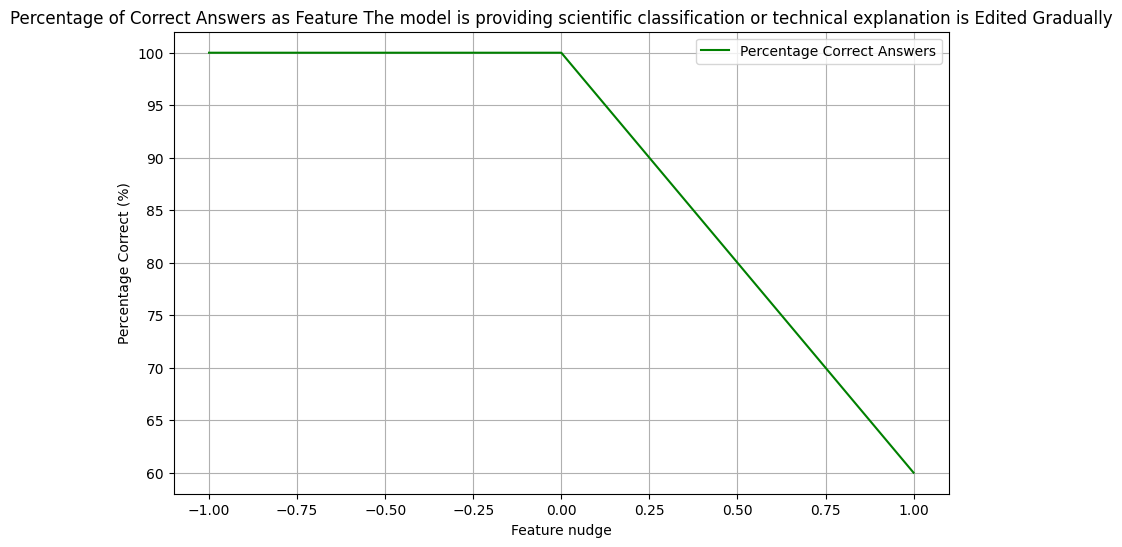

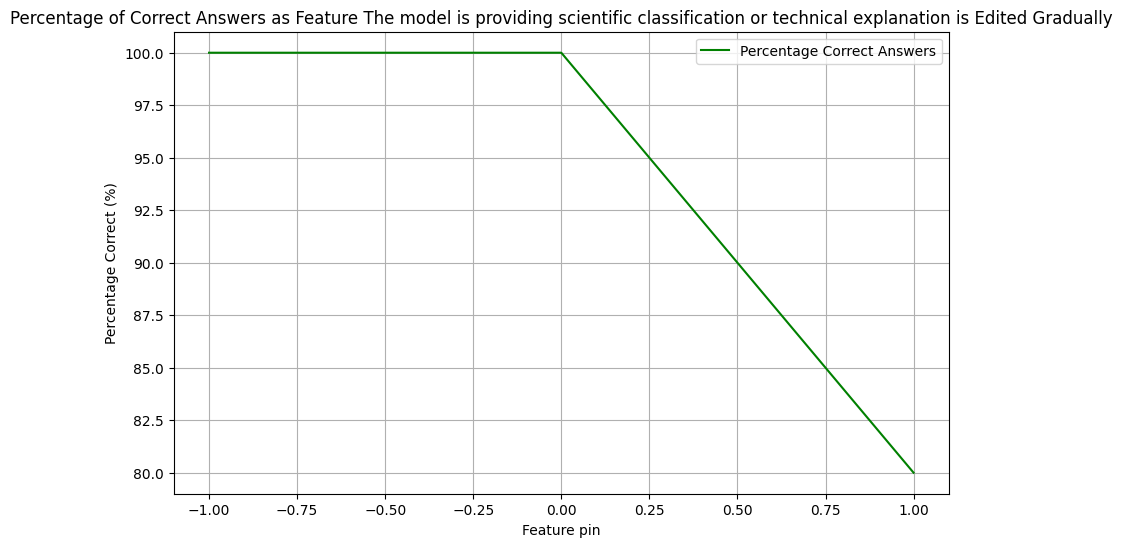

In [51]:

# Function to simulate gradual editing of the feature and computing correctness
def compute_correctness_with_feature_editing(data, nudged_feature=features[0], steering_mode="nudge", start_threshold = -1, end_threshold = 1, num_steps =20, verbose=False):
    """
    Gradually edits the feature (threshold) and computes the percentage of correct answers.
    """
    thresholds = np.linspace(start_threshold, end_threshold, num_steps)  # Gradual change in the feature (threshold)
    correct_percentages = []

    # TODO: parallelize this loop as well
    for steering_threshold in thresholds:
        if verbose:
            print(f"Running with {nudged_feature.label} set to {steering_threshold}...")
        global variant
        variant.reset()
        variant.set(nudged_feature, steering_threshold, mode = steering_mode) # TODO: try pinned as well
        responses = run_batch_api_calls(data)
        # compute correct_answers as the number of entries in responses that evaluated to 'correct'
        correct_answers = sum([(1 if response['correct'] else 0) for response in responses.values()])
        # Calculate the percentage of correct answers at this threshold
        correct_percentage = (correct_answers / len(data)) * 100
        correct_percentages.append(correct_percentage)

    return thresholds, correct_percentages

def plot_feature(data, nudged_feature, steering_mode='nudge', start_threshold = -1, end_threshold = 1, num_steps = 20, verbose = False):
    # Compute the correctness percentage over the gradual editing of the feature
    thresholds, correct_percentages = compute_correctness_with_feature_editing(data, nudged_feature=nudged_feature, steering_mode=steering_mode, start_threshold=start_threshold, end_threshold=end_threshold, num_steps=num_steps, verbose = verbose)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, correct_percentages, label="Percentage Correct Answers", color='green')
    plt.xlabel(f"Feature {steering_mode}")
    plt.ylabel("Percentage Correct (%)")
    plt.title(f"Percentage of Correct Answers as Feature {nudged_feature.label} is Edited Gradually")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{nudged_feature.label}.png")
    plt.show()

# Test
plot_feature(get_qa_indexed(5), nudged_feature=features[0], num_steps=3)
plot_feature(get_qa_indexed(5), nudged_feature=features[0], steering_mode='pin', num_steps=3)



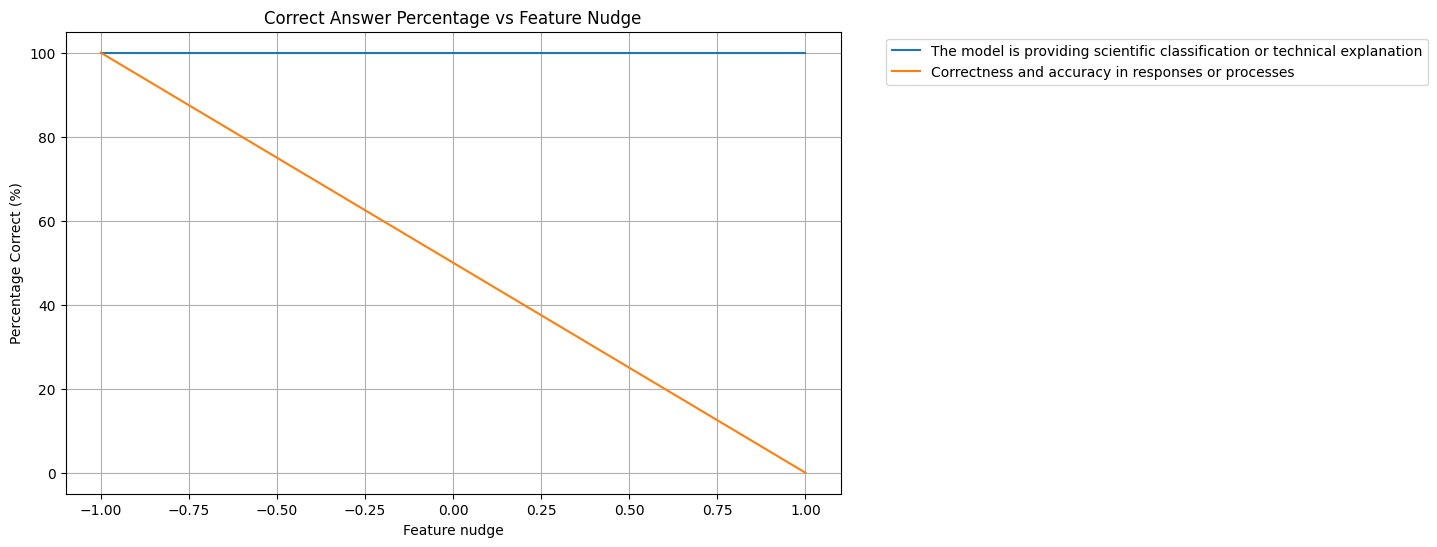

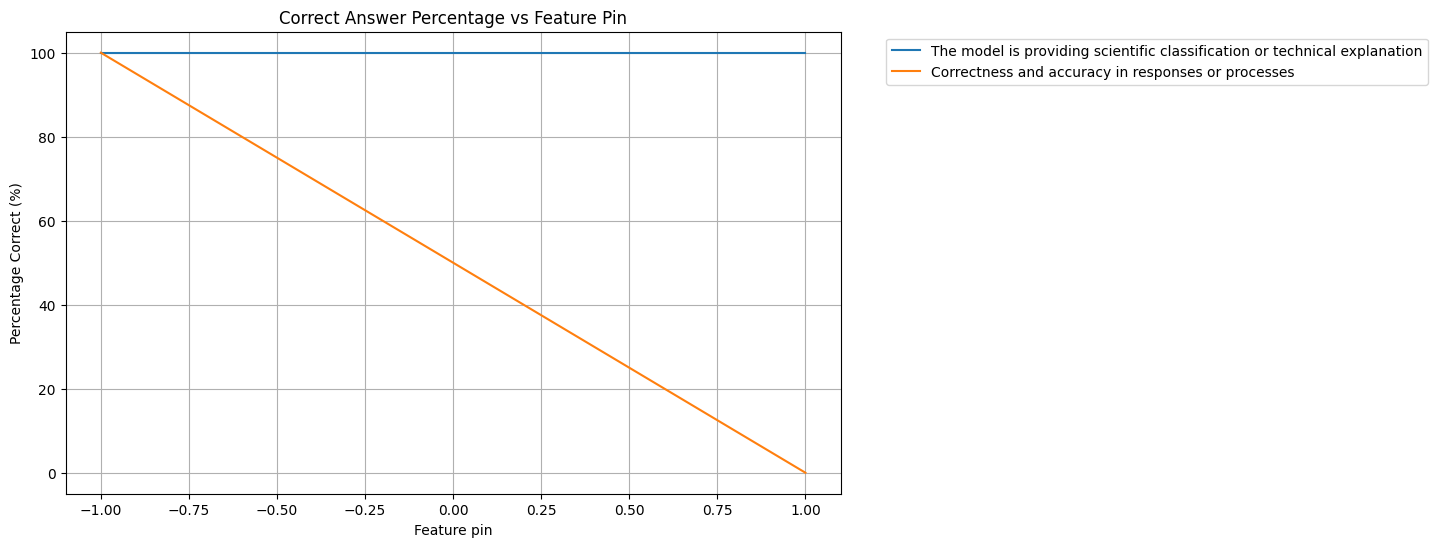

In [53]:
import time

def plot_multiple_features(data, nudged_features, steering_mode='nudge', start_threshold = -1, end_threshold = 1, num_steps = 9, verbose = False):
    plt.figure(figsize=(10, 6))
    for nudged_feature in nudged_features:
        # Compute the correctness percentage over the gradual editing of the feature
        thresholds, correct_percentages = compute_correctness_with_feature_editing(data, nudged_feature=nudged_feature, steering_mode=steering_mode, start_threshold=start_threshold, end_threshold=end_threshold, num_steps=num_steps, verbose = verbose)

        # Plot the results
        plt.plot(thresholds, correct_percentages, label=f"{nudged_feature.label}")
    plt.xlabel(f"Feature {steering_mode}")
    plt.ylabel("Percentage Correct (%)")
    if steering_mode == 'nudge':
        plt.title(f"Correct Answer Percentage vs Feature Nudge")
    else:
        plt.title(f"Correct Answer Percentage vs Feature Pin")
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    timestamp = int(time.time())
    plt.savefig(f"multiple_nudged_features_{timestamp}.png")
    plt.show()

# Test
plot_multiple_features(get_qa_indexed(1), nudged_features = features[:2], num_steps=2)
plot_multiple_features(get_qa_indexed(1), nudged_features = features[:2], steering_mode = "pin", num_steps=2)

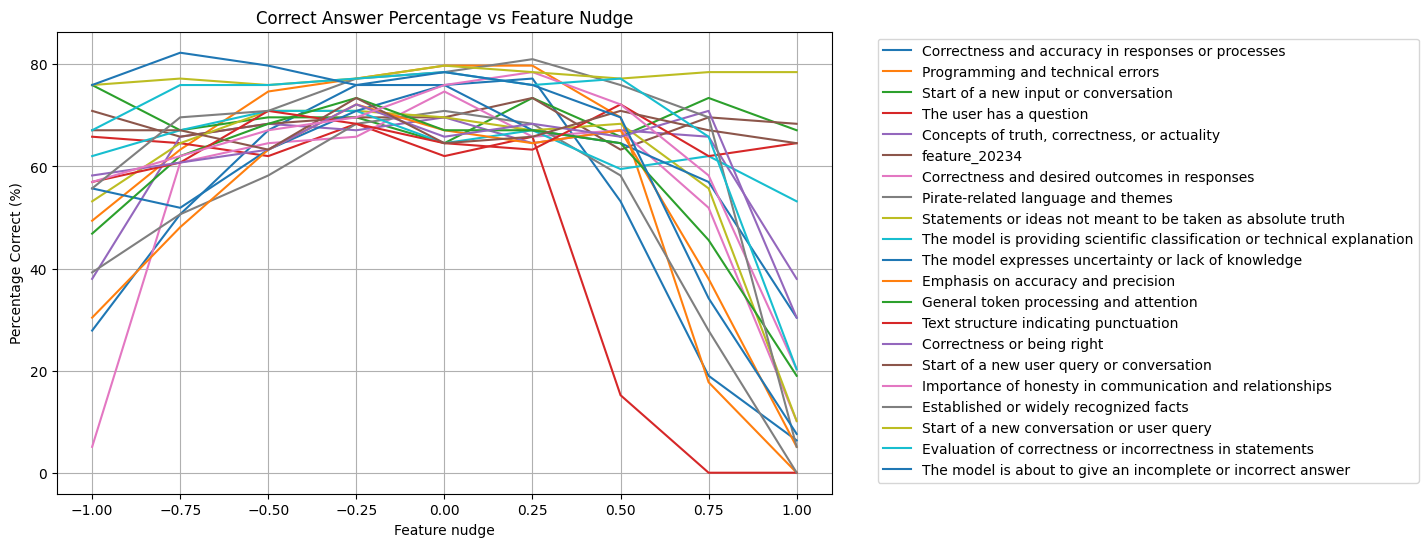

In [ ]:
#this cell generates graphs and will take a while to run, check desired num_steps before doing so

plot_multiple_features(get_qa_indexed(100), nudged_features = features, num_steps=9)

Streaming output truncated to the last 5000 lines.


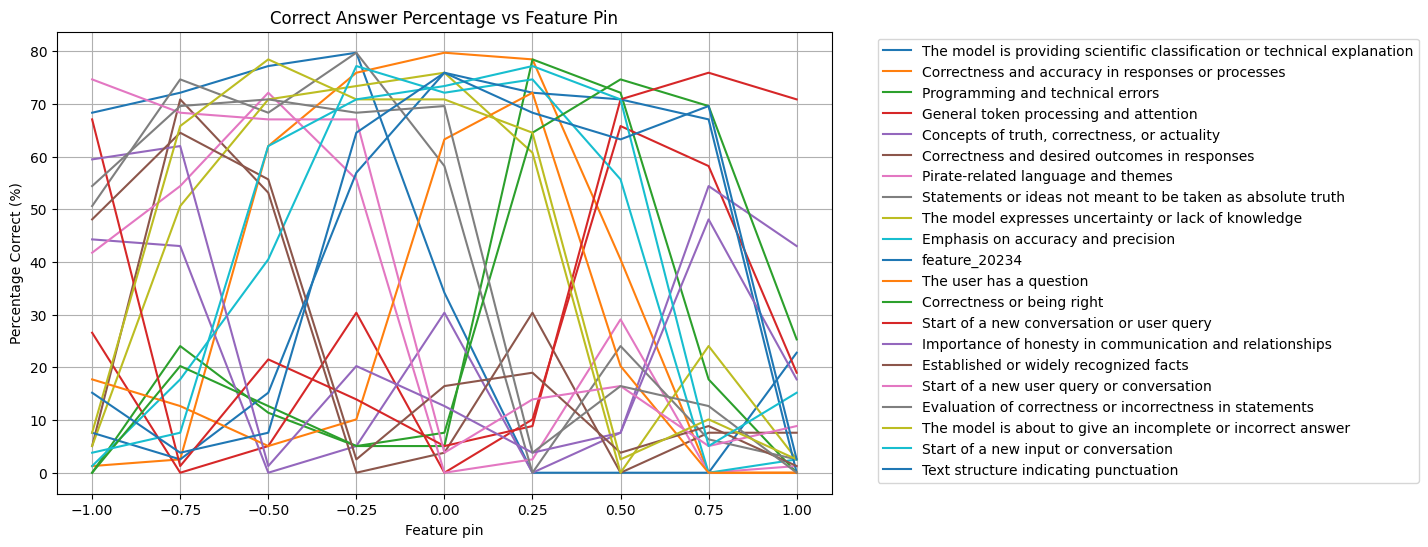

In [54]:
plot_multiple_features(get_qa_indexed(100), nudged_features = features, steering_mode = "pin", num_steps=9)

# Predicting truth values

By measuring activations of features, we can attempt to predict the truth value of certain statements.

In the section where we tested activations, we found two promising features with labels:
- "The model is about to give an incomplete or incorrect answer"
- "The user has a question"


In [ ]:
#TODO